# Robot Arm Kinematics (2D)

In [1]:
%matplotlib inline
from pylab import *
from numpy import sin, cos, pi, matrix, random
from __future__ import division
from math import atan2
rcParams['figure.figsize'] = 12, 10  # that's default image size for this interactive session
from IPython import display
from IPython.html.widgets import interact, fixed

/home/franz/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Coordinate Transformation

In [2]:
def trans(x, y, a):
    '''create a 2D transformation'''
    s = sin(a)
    c = cos(a)
    return matrix([[c, -s, x],
                   [s,  c, y],
                   [0,  0, 1]])

def from_trans(m):
    '''get x, y, theta from transform matrix'''
    return [m[0, -1], m[1, -1], atan2(m[1, 0], m[0, 0])]

In [3]:
trans(0, 0, 0)

matrix([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])

## Parameters of robot arm

In [4]:
N = 3  # number of links
l = [0] + range(N, 0, -1)  # length of link, l[0] is ingored
max_len = sum(l)
a = random.random_sample(N)  # angles of joints
T0 = trans(0, 0, 0)  # base

## Forward Kinematics

In [5]:
def forward_kinematics(T0, l, a):
    T = [T0]
    for i in range(len(a)):
        Ti = T[-1] * trans(l[i], 0, a[i])
        T.append(Ti)
    Te = T[-1] * trans(l[-1], 0, 0)  # end effector
    T.append(Te)
    return T

In [6]:
def show_robot_arm(T):
    cla()
    x = [Ti[0,-1] for Ti in T]
    y = [Ti[1,-1] for Ti in T]
    plot(x, y, '-or', linewidth=5, markersize=10)
    xlim([-max_len, max_len])
    ylim([-max_len, max_len]) 
    ax = axes()
    ax.set_aspect('equal')
    t = atan2(T[-1][1, 0], T[-1][0,0])
    ax.annotate('[%f,%f,%f]' % (x[-1], y[-1], t), xy=(x[-1], y[-1]), xytext=(x[-1], y[-1] + 0.5))
    display.clear_output(wait=True)

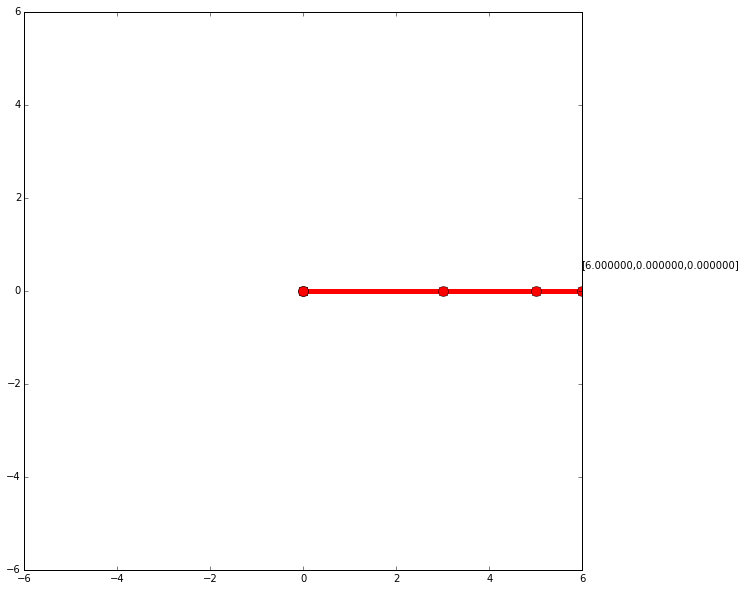

In [7]:
for i in range(N):
    @interact(value=(-pi/2, pi/2, 0.1), n=fixed(i))
    def set_joint_angle(n, value=0):
        global a
        a[n] = value
        T = forward_kinematics(T0, l, a)
        show_robot_arm(T)


## Inverse Kinematics

## Analytical Solutions with Sympy

[SymPy](http://sympy.org/) is a Python library for symbolic mathematics.

In [8]:
from sympy import init_printing, sin, cos, pi, asin, acos, atan2, atan, sqrt, simplify, solve, latex, symbols
from sympy import Matrix as matrix
init_printing()

In [9]:
from sympy.abc import x, y, theta
trans(x, y, theta)

ValueError: 
\left[\begin{smallmatrix}\cos{\left (\theta \right )} & - \sin{\left (\theta \right )} & x\\\sin{\left (\theta \right )} & \cos{\left (\theta \right )} & y\\0 & 0 & 1\end{smallmatrix}\right]
      ^
Expected "\right" (at char 6), (line:1, col:7)

⎡cos(θ)  -sin(θ)  x⎤
⎢                  ⎥
⎢sin(θ)  cos(θ)   y⎥
⎢                  ⎥
⎣  0        0     1⎦

In [ ]:
N = 4
l = [symbols('l_%d' % i) for i in range(N + 1)]
l[0] = 0
a = [symbols('theta_%d' % i) for i in range(N)]
T0 = trans(0, 0, 0)

In [10]:
l, a

([0, 3, 2, 1], array([ 0.,  0.,  0.]))

In [11]:
T0

matrix([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])

In [12]:
T = forward_kinematics(T0, l, a)
Te = T[-1]
Te

ValueError: 
\left[\begin{smallmatrix}1.0 & 0 & 6.0\\0 & 1.0 & 0\\0 & 0 & 1.0\end{smallmatrix}\right]
      ^
Expected "\right" (at char 6), (line:1, col:7)

⎡1.0   0   6.0⎤
⎢             ⎥
⎢ 0   1.0   0 ⎥
⎢             ⎥
⎣ 0    0   1.0⎦

In [13]:
Te = simplify(Te)
Te

ValueError: 
\left[\begin{smallmatrix}1.0 & 0 & 6.0\\0 & 1.0 & 0\\0 & 0 & 1.0\end{smallmatrix}\right]
      ^
Expected "\right" (at char 6), (line:1, col:7)

⎡1.0   0   6.0⎤
⎢             ⎥
⎢ 0   1.0   0 ⎥
⎢             ⎥
⎣ 0    0   1.0⎦

In [14]:
eq = Te * trans(x, y, theta).inv() - T0
eq

TypeError: cannot add matrix and <class 'numpy.matrixlib.defmatrix.matrix'>

In [15]:
eq = [a[0] + a[1] + a[2] - theta, eq[0, 2], eq[1, 2]]
eq

NameError: name 'eq' is not defined

In [16]:
solve(eq, a)  # sympy is too stupid to solve it

NameError: name 'eq' is not defined

In [17]:
b = [symbols('theta_%d' % i) for i in range(N)]
T3 = trans(x, y, theta) * trans(l[3], 0, 0).inv()
l_1_2 = T3[0,-1] ** 2 + T3[1,-1] ** 2
b_1_2 = acos((l[1] ** 2 + l[2] ** 2 - l_1_2) / (2 * l[1] * l[2]))  # cosine rule
b[1] = pi - b_1_2
b_1 = acos((l[1] ** 2 - l[2] ** 2 + l_1_2) / (2 * l[1] * sqrt(l_1_2)))  # cosine rule
b_0 = atan(T3[1,-1] / T3[0,-1])
b[0] = b_0 - b_1
b[2] = atan(T3[1,0] / T3[0,0]) - b[0] - b[1]
B = matrix([b]).T
B = simplify(B)
B

ValueError: 
\left[\begin{smallmatrix}- {acos}{\left (\frac{\left(x - \cos{\left (\theta \right )}\right)^{2} + \left(y - \sin{\left (\theta \right )}\right)^{2} + 5}{6 \sqrt{\left(x - \cos{\left (\theta \right )}\right)^{2} + \left(y - \sin{\left (\theta \right )}\right)^{2}}} \right )} + {atan}{\left (\frac{y - \sin{\left (\theta \right )}}{x - \cos{\left (\theta \right )}} \right )}\\- {acos}{\left (- \left(x - \cos{\left (\theta \right )}\right)^{2} / 12 - \left(y - \sin{\left (\theta \right )}\right)^{2} / 12 + \frac{13}{12} \right )} + \pi\\{acos}{\left (\frac{\left(x - \cos{\left (\theta \right )}\right)^{2} + \left(y - \sin{\left (\theta \right )}\right)^{2} + 5}{6 \sqrt{\left(x - \cos{\left (\theta \right )}\right)^{2} + \left(y - \sin{\left (\theta \right )}\right)^{2}}} \right )} + {acos}{\left (- \left(x - \cos{\left (\theta \right )}\right)^{2} / 12 - \left(y - \sin{\left (\theta \right )}\right)^{2} / 12 + \frac{13}{12} \right )} - {atan}{\left (\frac{y - \sin{\left (\theta \right )}}{x - \cos{\left (\theta \right )}} \right )} + {atan}{\left (\tan{\left (\theta \right )} \right )} - \pi\end{smallmatrix}\right]
      ^
Expected "\right" (at char 6), (line:1, col:7)

⎡                                     ⎛             2               2      ⎞  
⎢                                     ⎜ (x - cos(θ))  + (y - sin(θ))  + 5  ⎟  
⎢                               -     ⎜────────────────────────────────────⎟ +
⎢                                     ⎜     _______________________________⎟  
⎢                                 acos⎜    ╱             2               2 ⎟  
⎢                                     ⎝6⋅╲╱  (x - cos(θ))  + (y - sin(θ))  ⎠  
⎢                                                                             
⎢                                            ⎛              2               2 
⎢                                            ⎜  (x - cos(θ))    (y - sin(θ))  
⎢                                      - acos⎜- ───────────── - ───────────── 
⎢                                            ⎝        12              12      
⎢                                                                             
⎢    ⎛             2               2      ⎞       ⎛ 

In [36]:
print latex(B)

\left[\begin{matrix}- \operatorname{acos}{\left (\frac{l_{1}^{2} - l_{2}^{2} + \left(l_{3} \sin{\left (\theta \right )} - y\right)^{2} + \left(l_{3} \cos{\left (\theta \right )} - x\right)^{2}}{2 l_{1} \sqrt{\left(l_{3} \sin{\left (\theta \right )} - y\right)^{2} + \left(l_{3} \cos{\left (\theta \right )} - x\right)^{2}}} \right )} + \operatorname{atan}{\left (\frac{l_{3} \sin{\left (\theta \right )} - y}{l_{3} \cos{\left (\theta \right )} - x} \right )}\\- \operatorname{acos}{\left (\frac{1}{2 l_{1} l_{2}} \left(l_{1}^{2} + l_{2}^{2} - \left(l_{3} \sin{\left (\theta \right )} - y\right)^{2} - \left(l_{3} \cos{\left (\theta \right )} - x\right)^{2}\right) \right )} + \pi\\\operatorname{acos}{\left (\frac{1}{2 l_{1} l_{2}} \left(l_{1}^{2} + l_{2}^{2} - \left(- l_{3} \sin{\left (\theta \right )} + y\right)^{2} - \left(- l_{3} \cos{\left (\theta \right )} + x\right)^{2}\right) \right )} + \operatorname{acos}{\left (\frac{l_{1}^{2} - l_{2}^{2} + \left(- l_{3} \sin{\left (\theta \right )} +

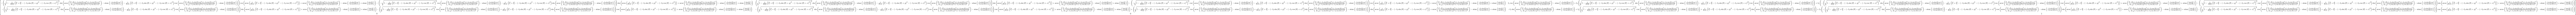

In [37]:
T_new = forward_kinematics(T0, l, b)
Te_new = T_new[-1]
Te_new

In [38]:
simplify(Te_new[0, 0])

KeyboardInterrupt: 

In [ ]:
simplify(Te_new[1, 0])

In [ ]:
simplify(Te_new[0, -1])

### Test the analytical solution

In [57]:
from numpy import sin, cos, pi, matrix
from math import atan2, acos

T0 = trans(0, 0, 0)
lv = [0] + range(N, 0, -1)  # length of link, l[0] is ingored
bf = B
for i in range(N):
    bf = bf.subs(l[i + 1], lv[i + 1])

def inverse_kinematics(x_e, y_e, theta_e):
    b = bf.subs(x, x_e).subs(y, y_e).subs(theta, theta_e)
    b = (b.subs('I', 1).subs('pi', pi).tolist())
    b = [float(i[0]) for i in b]
    return b
    
@interact(x_e=(0, max_len, 0.1), y_e=(-max_len, max_len, 0.1), theta_e=(-pi, pi, 0.1))
def set_end_effector(x_e=6, y_e=0, theta_e=0):
    b = inverse_kinematics(x_e, y_e, theta_e)
    T = forward_kinematics(T0, lv, b)
    show_robot_arm(T)

AttributeError: 'numpy.ndarray' object has no attribute 'is_Add'

### Numerical Solution

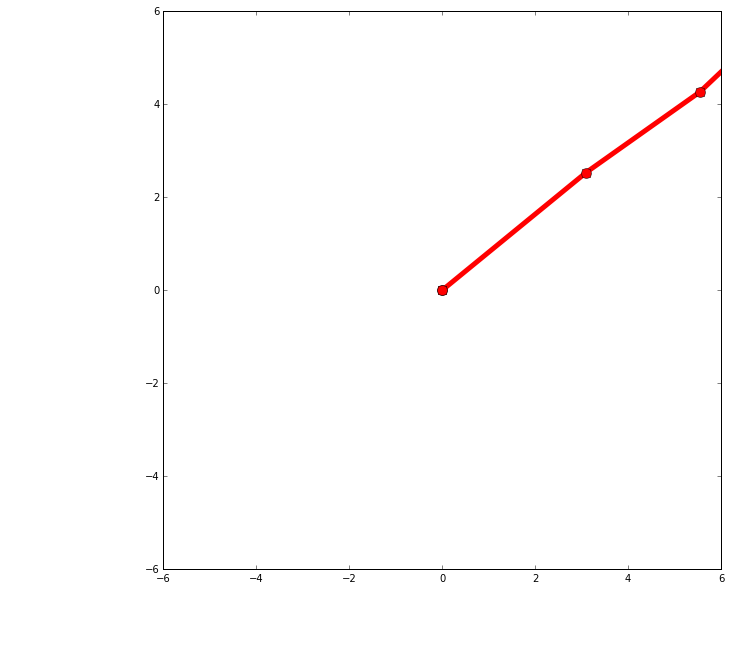

In [68]:
from numpy import asarray
theta = asarray([0.1] * N)
def inverse_kinematics(x_e, y_e, theta_e, theta):
    target = matrix([[x_e, y_e, theta_e]])
    while True:
        T = forward_kinematics(T0, lv, theta)
        Te = matrix([from_trans(T[-1])])
        e = target - Te
        T = matrix([from_trans(i) for i in T[1:-1]])
        J = Te - T
        J = J.T
        J[-1, :] = 1
        JJT = J * J.T
        d_theta = 0.001 * J.T * JJT.I * e.T
        #print (d_theta.T * d_theta)[0, 0]
        theta += asarray(d_theta.T)[0]
        if (d_theta.T * d_theta)[0, 0] < 1e-6:
            break
    return theta

T = forward_kinematics(T0, lv, theta)
Te = matrix([from_trans(T[-1])])

@interact(x_e=(0, max_len, 0.01), y_e=(-max_len, max_len, 0.01), theta_e=(-pi, pi, 0.01), theta=fixed(theta))
def set_end_effector(x_e=Te[0,0], y_e=Te[0,1], theta_e=Te[0,2], theta=theta):
    theta = inverse_kinematics(x_e, y_e, theta_e, theta)
    T = forward_kinematics(T0, lv, theta)
    show_robot_arm(T)